In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from keras.preprocessing.text import Tokenizer
from keras.layers import Activation, Dense, Reshape 
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from keras.models import load_model
from numpy import asarray
from numpy import save
from numpy import load
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import esprima as esp
import re
from keras.initializers import Constant
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import plot_model
from keras import Model
import keras
import pydot
import gensim 
from nltk.tokenize import word_tokenize
import pickle
from keras import backend as K

plt.style.use('ggplot')

In [122]:
def save_object(obj, filename):
    with open(filename+".pkl", 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
    outp.close()

In [123]:
def load_object(filename):
    with open(filename+".pkl", 'rb') as outp:
        loaded_object = pickle.load(outp)
    outp.close()
    return loaded_object

In [4]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [124]:
def preprocessing_dataset_(scripts,fit = True):
    if fit:
        tokenizer = Tokenizer(num_words=num_words)
        tokenizer.fit_on_texts(scripts)
        our_tokenizer = save_object(tokenizer, "our_tokenizer")
    else :
        tokenizer = load_object("our_tokenizer")
    X = tokenizer.texts_to_sequences(scripts)
    if fit:
        vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
        save_object(vocab_size, "vocab_size")
    X = pad_sequences(X, padding='post', maxlen=maxlen)
    return X

In [6]:
# convert java script code to the abstract syntax tree
# then extract the sequences of syntax units with detailed information
def sequence_of_syntax_units(scripts):
    """
    sctipts : list or single javascript code 
    return sequence of syntax units
    each syntax unit correspond to line in an abstract syntax tree
    """
    if type(scripts) is list:
        # esp.parseScript(script) returns abstract syntax tree of each js scripts
        return [re.sub('\s+', ' ', ''.join(str(esp.parseScript(script)).split('\n'))) for script in scripts]
    elif type(scripts) is str:
        return re.sub('\s+', ' ', ''.join(str(esp.parseScript(scripts)).split('\n')))
    else:
        raise ValueError('The type of scripts parameter must be {list or string}')

In [7]:
# create word tokens
def sequence_of_syntax_units_to_tokens(seq_of_syn_units):
    """
    Convert Sequence of syntax units to tokens to train  word2vec model 
    -----------------------------------------
    seq_of_syn_units: list of sequence syntax units correspond to abstract syntax trees
    """
    return list(map(word_tokenize, seq_of_syn_units))

In [10]:
class CustomDataGen(keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,batch_size,test=0,shuffle=True,sub_path=""):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.test = test ****
        self.shuffle = shuffle
        self.sub_path = sub_path
        self.n = df.shape[0]
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path):
        try:
            with open(os.path.join(self.sub_path,path)) as js_file: ****
                script = js_file.read()
            script = sequence_of_syntax_units(script)
            return script
        except:
            return 'None'
    def __get_output(self, label):
        return label
#         return keras.utils.to_categorical(label, num_classes=2)
    
    def __get_data(self, batches):

        path_batch = batches[self.X_col['path']]
        
        name_batch = batches[self.y_col['name']]

        X_batch = np.asarray([self.__get_input(x) for x in path_batch]).astype('object')
        
        y_batch = np.asarray([self.__get_output(y) for y in name_batch]).astype('object')
        
        index = np.where(X_batch=='None')[0]
        
        np.delete(X_batch, index, axis=0)
        np.delete(y_batch, index, axis=0)
        
        X_batch  = preprocessing_dataset_(X_batch , fit = self.test ) *****
        
        X_batch = K.cast_to_floatx(X_batch)
        y_batch = K.cast_to_floatx(y_batch)
        

        return X_batch, y_batch
    
    def __getitem__(self, index):
        
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [16]:
# def evaluation_generator(model,history,X_train,X_test=None):    
#     loss, accuracy = model.evaluate_generator(X_train)
#     print("Training Accuracy: {:.4f}".format(accuracy))
#     if X_test:
#         loss, accuracy = model.evaluate_generator(X_test)
#         print("Testing Accuracy:  {:.4f}".format(accuracy))
#         plot_history(history)

In [21]:
def evaluation(model,history,X_train,y_train,X_test=0,y_test=0,with_test=False):
    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    if with_test:
        loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
        print("Testing Accuracy:  {:.4f}".format(accuracy))
        print(classification_report(np.round(model.predict(X_test)), y_test))
        plot_history(history)

In [22]:
def create_model(shape=100,without_lstm=False):
    model = Sequential()
    if not without_lstm:
        model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
        model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))
    else :
         model.add(layers.InputLayer(input_shape=shape))
        
    
    model.add(Bidirectional(LSTM(units=50, input_shape=(None, 50), return_sequences=True)))

    # TextCNN with 4 conv layers
    model.add(Conv1D(128, 7, activation='tanh', input_shape=(None, 32)))
    model.add(Conv1D(128, 15, activation='tanh'))
    model.add(Conv1D(128, 25, activation='tanh'))
    model.add(Conv1D(128, 35, activation='tanh'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=myoptimizer,
                  loss=myloss,
                  metrics=[mymetrics])
    model.summary()
    return model

In [23]:
def fit_generator_model(model,model_name,training_generator,validation_data=0,with_test=False):
    model_name = str(model_name)+".h5"
    if with_test:
        history = model.fit_generator(generator=training_generator,epochs=10,verbose=False,validation_data=validation_data)
    else:
        history = model.fit_generator(generator=training_generator,epochs=10,verbose=False)
    model.save(model_name)
    return model , history , model_name

In [24]:
def fit_model(model,model_name,X_train,y_train,X_test=0,y_test=0,with_test=False): **********
    model_name = str(model_name)+".h5"
    if with_test:
        history = model.fit(X_train, y_train,epochs=10,verbose=False,validation_data=(X_test, y_test))
    else:
        history = model.fit(X_train, y_train,epochs=10,verbose=False)
    model.save(model_name)
    return model , history , model_name

In [62]:
my_df = pd.read_csv('G:/JSContanaDataSet/script_path_data.csv')
my_test_df = pd.read_csv('G:/JSContanaDataSet/script_path_test_data.csv')

my_batch_size = 20
path_train_data = 'G:/JSContanaDataSet/script__df.csv'
# num_words = 400000
num_words = 400
# maxlen = 1024
maxlen = 100
embedding_dim = 50
myoptimizer = 'adam'
myloss= 'binary_crossentropy'
mymetrics = 'accuracy'

traingen = CustomDataGen(my_df[:1000],
                         X_col={'path':'ScriptPath'},
                         y_col={'name': 'Label'},
                         batch_size=my_batch_size,
                         sub_path='G:/JSContanaDataSet/',
                         test=0)

testgen = CustomDataGen(my_test_df[:500],
                         X_col={'path':'ScriptPath'},
                         y_col={'name': 'Label'},
                         batch_size=10,
                         sub_path='G:/JSContanaDataSet/',
                         test=1)
print(list(traingen)[0][0].shape)
vocab_size = load_object('vocab_size')


(20, 100)


In [28]:
train_test_Model = Model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           69200     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 94, 128)           89728     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 80, 128)           245888    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 56, 128)           409728    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 22, 128)          

In [29]:
train_test_Model , train_test_Model_history , train_test_Model_model_name = fit_generator_model(train_test_Model,"train_test_Model",traingen,testgen,with_test=True)

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.evaluate, which supports generators.
Training Accuracy: 0.5000
Testing Accuracy:  0.5140


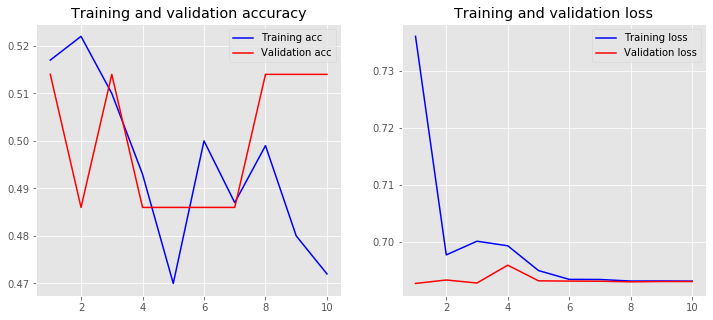

In [30]:
evaluation_generator(train_test_Model,train_test_Model_history,traingen,testgen,with_test=True)

In [50]:
x , y = traingen.__getitem__(0)
xx = [] 
yy = []
for i in range(1,int(my_df[:1000].shape[0]/my_batch_size)):
    xx.append(traingen.__getitem__(i)[0])
    yy.append(traingen.__getitem__(i)[1])

In [ ]:
for i in range(0,len(xx)):
    x = np.concatenate((x, xx[i]), axis=0)
    y = np.concatenate((y, yy[i]), axis=0)

In [113]:
x_ , y_ = testgen.__getitem__(0)
xx_ = [] 
yy_ = []
for i in range(1,int(my_test_df[:500].shape[0]/10)):
    xx_.append(testgen.__getitem__(i)[0])
    yy_.append(testgen.__getitem__(i)[1])

In [114]:
for i in range(0,len(xx_)):
    x_ = np.concatenate((x_, xx_[i]), axis=0)
    y_ = np.concatenate((y_, yy_[i]), axis=0)

Training Accuracy: 0.5000
Testing Accuracy:  0.5000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.50      0.67       250

    accuracy                           0.50       250
   macro avg       0.50      0.25      0.33       250
weighted avg       1.00      0.50      0.67       250



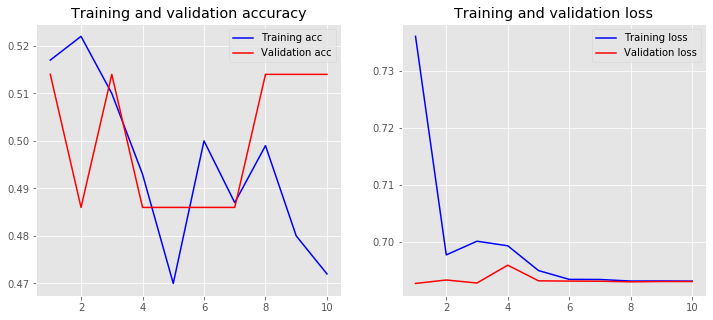

In [47]:
evaluation(train_test_Model,train_test_Model_history,x[:750],y[:750],x[750:1000],y[750:1000],with_test=True)

In [74]:
_for_traingen_[:20]

(20, 100, 100)

In [31]:
# keras_function = K.function([train_test_Model.input], [train_test_Model.layers[1].output])
# for_traingen = []
# for i in range(int(my_df[:1000].shape[0]/my_batch_size)):
#     first_layer_output = keras_function([list(traingen)[i][0], 1])
#     for_traingen.append(first_layer_output[0])
# _for_traingen_ = for_traingen[0]
# for i in for_traingen[1:]:
#     _for_traingen_ = np.concatenate((_for_traingen_, i), axis=0)
# save_object(_for_traingen_, "_for_traingen_")
_for_traingen_ = load_object("_for_traingen_")

In [38]:
_for_traingen_.shape

(1000, 100, 100)

In [32]:
# clear_session()

In [33]:
#######################################################

In [39]:
Model_without_first_layer = Model(shape=_for_traingen_[0].shape,without_lstm=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 94, 128)           89728     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 80, 128)           245888    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 56, 128)           409728    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 22, 128)           573568    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [40]:
Model_without_first_layer,history_Model_without_first_layer,name_Model_without_first_layer=fit_model(Model_without_first_layer,"Model_without_first_layer",_for_traingen_[:750],np.array(my_df['Label'][:750]),_for_traingen_[750:1000],np.array(my_df['Label'][750:1000]),with_test=True)

Training Accuracy: 0.5000
Testing Accuracy:  0.5000


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67       250
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50       250
   macro avg       0.50      0.25      0.33       250
weighted avg       1.00      0.50      0.67       250



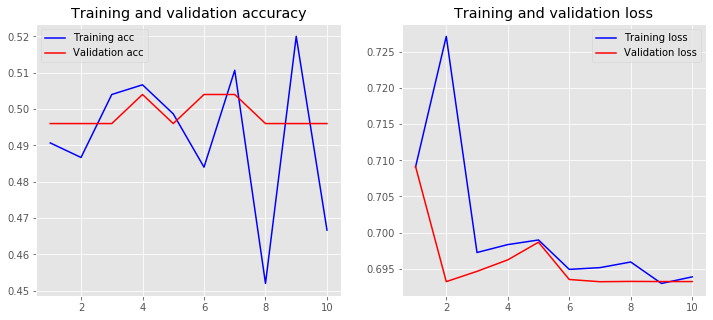

In [48]:
evaluation(Model_without_first_layer,history_Model_without_first_layer,_for_traingen_[:750],y[:750],_for_traingen_[750:1000],y[750:1000],with_test=True)

In [88]:
# clear_session()

In [76]:
test_Model = Model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           63550     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 100)          40400     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 94, 128)           89728     
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 80, 128)           245888    
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 56, 128)           409728    
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 22, 128)          

In [77]:
test_Model , test_Model_history , test_Model_model_name = fit_generator_model(test_Model,"train_test_Model",testgen,with_test=False)

In [81]:
keras_function = K.function([test_Model.input], [test_Model.layers[1].output])
for_testgen = []
for i in range(int(my_test_df[:500].shape[0]/10)):
    first_layer_output = keras_function([list(testgen)[i][0], 1])
    for_testgen.append(first_layer_output[0])
_for_testgen_ = for_testgen[0]
for i in for_testgen[1:]:
    _for_testgen_ = np.concatenate((_for_testgen_, i), axis=0)
save_object(_for_testgen_, "_for_testgen_")
_for_testgen_ = load_object("_for_testgen_")

In [119]:
for_traingen[0].shape

(20, 100, 100)

In [118]:
yy[0].shape

(20,)

In [115]:
for_testgen[0].shape

(10, 100, 100)

In [116]:
yy_[0].shape

(10,)

=================================== chunk 0 ========================================
***********for first model****************
Training Accuracy: 0.5000
Testing Accuracy:  0.4000
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.40      0.57        10

    accuracy                           0.40        10
   macro avg       0.50      0.20      0.29        10
weighted avg       1.00      0.40      0.57        10

***********for second model****************


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: in user code:

    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 test_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1215 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1208 run_step  **
        outputs = model.test_step(data)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1174 test_step
        y_pred = self(x, training=False)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\wrappers.py:530 __call__
        return super(Bidirectional, self).__call__(inputs, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer bidirectional_5 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 100, 100, 50]


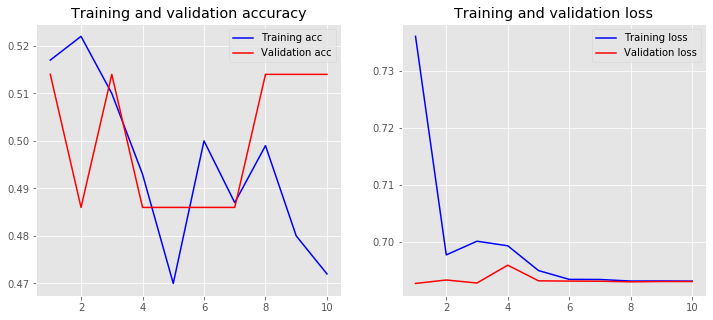

In [121]:
for i in range(0,len(yy_)):
    print("=================================== chunk "+str(i)+" ========================================")
    print("***********for first model****************")
    evaluation(train_test_Model,train_test_Model_history,xx[i],yy[i],xx_[i],yy_[i],with_test=True)
    print("***********for second model****************")
    evaluation(test_Model,test_Model_history,for_traingen[i],yy[i],for_testgen[i],yy_[i],with_test=True)

In [ ]:
vocab_size